In [1]:
#Import any library here only.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.model_sitction import train_test_split
from imblearn.over_sampling import RandomOverSampler
import shutil
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import roc_auc_score
from keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [4]:
''' Do not change this cell '''
#Functions

def check_gpu():
  if tf.test.gpu_device_name() != '':
    print("GPU sucessfully connected")
  else: print("PLease connect GPU")

def check_data():
  a = set()
  for image in Images:
    a.add(Image.shape[2])
  if len(a)==1 and len(Images)==624:
    print("PASS")
  else: print("FAIL")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color='orange'>Task #1</font>

Data loading and understanding data

In [7]:
! unzip /content/drive/MyDrive/OpenCodeData.zip

Archive:  /content/drive/MyDrive/OpenCodeData.zip
   creating: OpenCodeData/OpenCodeData/
   creating: OpenCodeData/OpenCodeData/INFECTED/
  inflating: OpenCodeData/OpenCodeData/INFECTED/person1_virus_11.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person1_virus_12.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person1_virus_13.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person1_virus_6.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person1_virus_7.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person1_virus_8.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person1_virus_9.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person10_virus_35.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person100_bacteria_475.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person100_bacteria_477.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person100_bacteria_478.jpeg  
  inflating: OpenCodeData/OpenCodeData/INFECTED/person

In [5]:
''' Do not change this cell '''
check_gpu()

GPU sucessfully connected


In [8]:
#Create two lists, images and labels. Store Input images in 'Images' list and its labels in 'Labels' list.
#Infected Images have two categories viral and bacterial. Find Number of images in each class. (Hint: See image name)
#Note that images are of different sizes.
images = []
labels = []
viral_ct=0
bacteria_ct=0
normal_ct=0
infected_ct=0
def process_images(dir,label):
  filename = os.listdir(dir)
  for img in tqdm(filename):
    path = os.path.join(dir,img)
    labels.append(label)
    image = cv2.imread(path)
    images.append(image)

def infected_category(dir):
  filename = os.listdir(dir)
  for img in tqdm(filename):
    path = os.path.join(dir,img)
    if 'virus' in img:
      labels.append("virus")
    elif 'bacteria' in img:
      labels.append("bacteria")
    else:
      labels.append("unidentified")
    image = cv2.imread(path)
    images.append(image)

process_images('/content/OpenCodeData/OpenCodeData/INFECTED',"infected")
process_images('/content/OpenCodeData/OpenCodeData/NORMAL',"normal")
infected_category('/content/OpenCodeData/OpenCodeData/INFECTED')
viral_ct+=labels.count("virus")
bacteria_ct+=labels.count("bacteria")
normal_ct+=labels.count("normal")
infected_ct+=labels.count("infected")

print(f"\n Viral Image Count: {viral_ct}")
print(f"\n Bacteria Image Count: {bacteria_ct}")
print(f"\n Normal Image Count: {normal_ct}")
print(f"\n Infected Image Count: {infected_ct}")



100%|██████████| 390/390 [00:02<00:00, 134.17it/s]


 Viral Image Count: 148

 Bacteria Image Count: 242

 Normal Image Count: 234

 Infected Image Count: 390


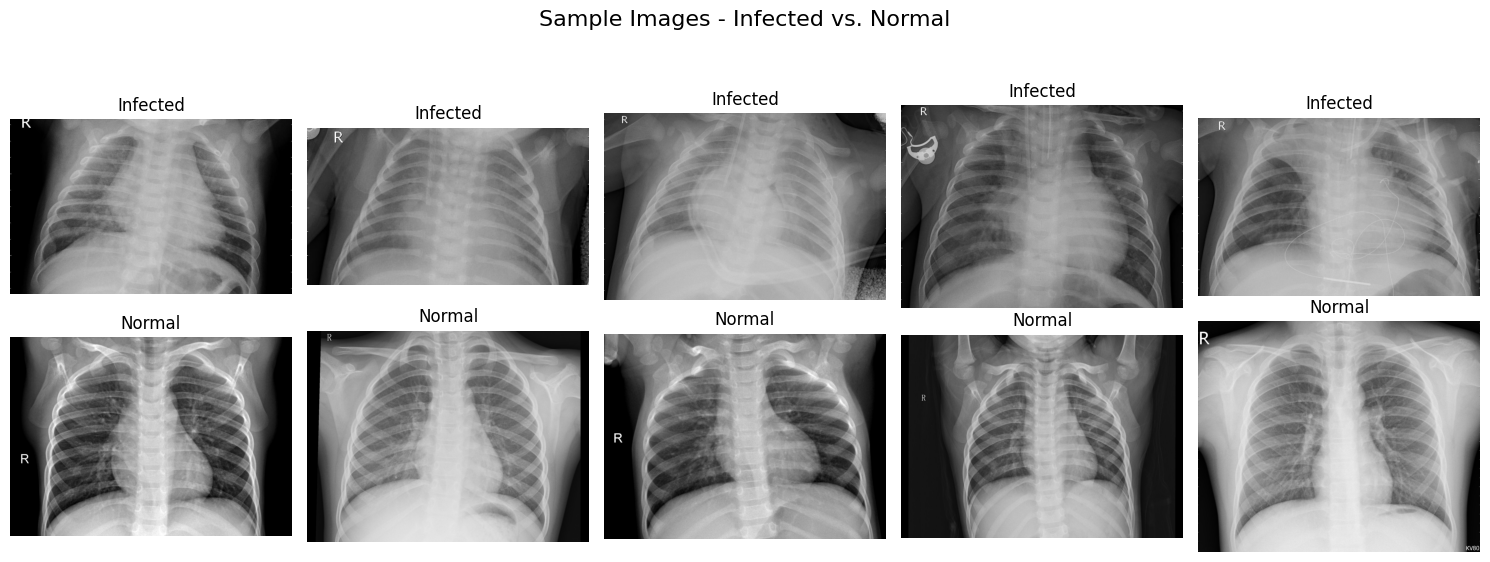

In [9]:
infected_folder = '/content/OpenCodeData/OpenCodeData/INFECTED'
normal_folder = '/content/OpenCodeData/OpenCodeData/NORMAL/'

infected_images = [Image.open(os.path.join(infected_folder, img)).convert('RGB') for img in os.listdir(infected_folder)[:5]]
normal_images = [Image.open(os.path.join(normal_folder, img)).convert('RGB') for img in os.listdir(normal_folder)[:5]]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axes[0, i].imshow(infected_images[i])
    axes[0, i].set_title("Infected")
    axes[0, i].axis('off')

    axes[1, i].imshow(normal_images[i])
    axes[1, i].set_title("Normal")
    axes[1, i].axis('off')
plt.suptitle('Sample Images - Infected vs. Normal', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [28]:
all_images = image_dataset_from_directory("/content/OpenCodeData/OpenCodeData",batch_size = 624)

Found 624 files belonging to 2 classes.


In [148]:
itr = all_images.as_numpy_iterator()
batch = itr.next()

In [149]:
x = batch[0].reshape(batch[0].shape[0] , -1)
y = batch[1]

In [150]:
increase = RandomOverSampler()
X,Y = increase.fit_resample(x,y)

In [151]:
X.shape

(780, 196608)

In [152]:
Y.shape

(780,)

In [153]:
def plot_images(image_list, labels):
    plt.figure(figsize=(12, 6))
    for i in range(len(image_list)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image_list[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [154]:
def preprocess(image):
  image = image / 255
  return image

In [155]:
X = X.reshape(X.shape[0],256,256,3)
X = preprocess(X)

In [26]:
#Pre-processing all the images
infected_images = [Image.open(os.path.join(infected_folder, img)) for img in os.listdir(infected_folder)]
normal_images = [Image.open(os.path.join(normal_folder, img)) for img in os.listdir(normal_folder)]

In [27]:
#All images pre-processed
pre_normal_images = [pre_processing(img) for img in normal_images]
pre_infected_images = [pre_processing(img) for img in infected_images]
pre_all_images = [pre_processing(img) for img in all_images]

In [156]:
dataset = tf.data.Dataset.from_tensor_slices((X,Y),)
dataset =dataset.shuffle(100).batch(32)
train_size = int(len(dataset)*.7)
val_size = int(len(dataset)*.2)
test_size = int(len(dataset)*.1)+1

train_images = dataset.take(train_size)
val_images = dataset.skip(train_size).take(val_size)
test_images = dataset.skip(train_size+val_size).take(test_size)

MODEL BUILDING

In [198]:
# Create a Sequential model
model = Sequential()

model.add(Conv2D(16, (3, 3), 1,activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3),1, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  #for other layers, activation relu, for final sigmoid, as for binary classification

# Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',AUC()])

# Model Summary
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 30, 30, 16)      

In [199]:
hist = model.fit(train_images,batch_size = 32 , epochs=15, validation_data=val_images)


Epoch 1/15
17/17 [==============================] - 7s 87ms/step - loss: 0.6886 - accuracy: 0.6599 - auc_15: 0.5816 - val_loss: 0.8426 - val_accuracy: 0.2062 - val_auc_15: 0.8618
Epoch 2/15
17/17 [==============================] - 1s 55ms/step - loss: 0.5109 - accuracy: 0.7923 - auc_15: 0.8373 - val_loss: 0.3801 - val_accuracy: 0.8250 - val_auc_15: 0.8946
Epoch 3/15
17/17 [==============================] - 1s 56ms/step - loss: 0.2851 - accuracy: 0.8971 - auc_15: 0.9501 - val_loss: 0.4446 - val_accuracy: 0.8250 - val_auc_15: 0.9452
Epoch 4/15
17/17 [==============================] - 1s 47ms/step - loss: 0.2337 - accuracy: 0.9062 - auc_15: 0.9651 - val_loss: 0.2324 - val_accuracy: 0.9000 - val_auc_15: 0.9733
Epoch 5/15
17/17 [==============================] - 1s 47ms/step - loss: 0.1691 - accuracy: 0.9375 - auc_15: 0.9810 - val_loss: 0.2815 - val_accuracy: 0.9000 - val_auc_15: 0.9852
Epoch 6/15
17/17 [==============================] - 1s 52ms/step - loss: 0.1313 - accuracy: 0.9412 - auc_

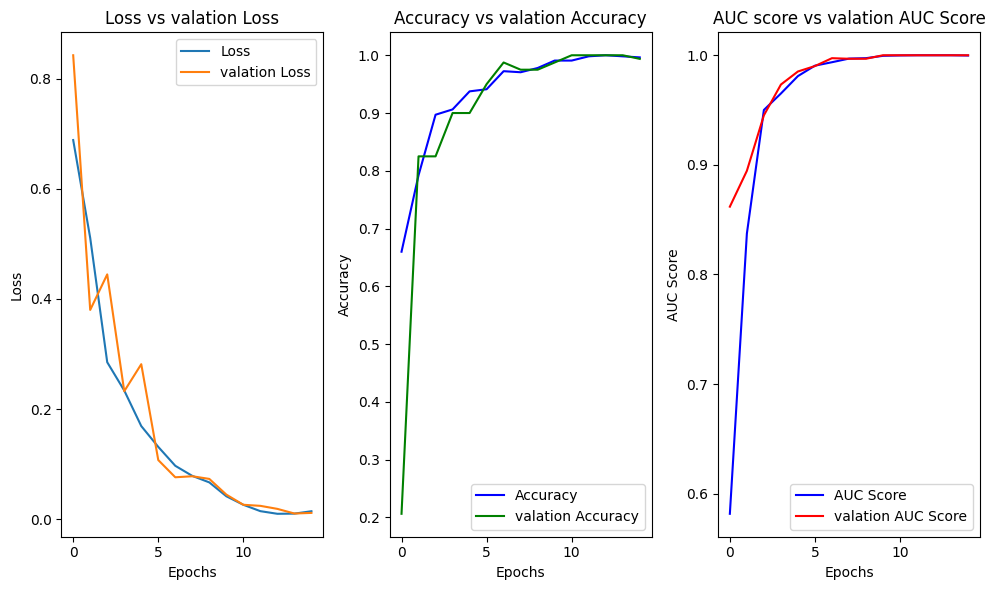

In [207]:
#Loss vs valation loss
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='valation Loss')
plt.title('Loss vs valation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Accuracy vs valation Accuracy
plt.subplot(1, 3, 2)
plt.plot(hist.history['accuracy'],'b', label='Accuracy')
plt.plot(hist.history['val_accuracy'],'g', label='valation Accuracy')
plt.title('Accuracy vs valation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# AUC vs valation AUC
plt.subplot(1, 3, 3)
plt.plot(hist.history['auc_15'], 'b', label='AUC Score')
plt.plot(hist.history['val_auc_15'], 'r', label='valation AUC Score')
plt.title('AUC score vs valation AUC Score')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

plt.tight_layout()
plt.show()


In [203]:
y_true = []
y_predict = []
for batch in test_images.as_numpy_iterator():
  X,y = batch
  for it in y:
    y_true.append(it)
  yhat = model.predict(X)
  for it in yhat:
    if it>=0.5 :
      y_predict.append(1)
    else:
      y_predict.append(0)

1/1 [==============================] - 0s 42ms/step


In [204]:
auc_score = roc_auc_score(y_true, y_predict)
print(auc_score)

1.0


TESTING MODEL


In [206]:

test_loss, test_accuracy,test_auc = model.evaluate(test_images)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC Score: {test_auc}")


3/3 [==============================] - 0s 23ms/step - loss: 0.0021 - accuracy: 1.0000 - auc_15: 1.0000
Test Loss: 0.0021476615220308304
Test Accuracy: 1.0
Test AUC Score: 0.9999999403953552


CONFUSION MATRIX


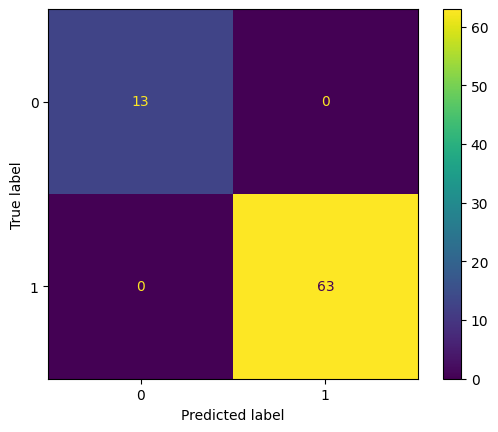

In [211]:
mat= confusion_matrix(y_true, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=mat)
disp.plot()
plt.show()

SAVING MODEL

In [212]:
model.save('CNN_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
